In [5]:
import numpy as np
import png
import pydicom
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import os
import torch
import torch.nn as nn
from torchvision.transforms import Compose
import transform_classes
import pandas as pd
import preprocess_img

In [2]:
from roi import RoiLearn
from roi_dataset import RoiDataset
from autoencoder import Autoencoder
from preprocessor import Preprocessor
from PIL import Image
from autoencoder_dataset import AEDataset

In [3]:
# if we don't have the .csv file
preprocess_img.write_all_rectangle2file('O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_1\\')

Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!


Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!


## For modifying pre-path. --------------------------

In [10]:
csv_file = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_1\\rectangle.csv'
contour_data = pd.read_csv(csv_file,sep=';', names=('path','slice', 'frame', 'xmin', 'ymin', 'height','width' ))
contour_data['path'][0]

'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_1\\17108976AMR804\\1001\\imgs\\1.3.46.670589.11.22133.5.0.4480.2017032208054948780.dcm'

In [21]:
contour_data = pd.read_csv(csv_file,sep=';', names=('path','slice', 'frame', 'xmin', 'ymin', 'height','width' ))
contour_data['path'] = (contour_data['path'].apply(lambda x: '/userhome/student/kede/heart_contour/heart_contour/sa_all_1/' + x.rsplit('\\', 4)[1] + '/'+ x.rsplit('\\', 4)[2] + '/'+x.rsplit('\\', 4)[3]+ '/'+x.rsplit('\\', 4)[4])[0])

In [25]:
contour_data.to_csv(csv_file, sep=';', index=False, header=False)

# ----------------------------------------------------

In [3]:
print(torch.device('cuda'))

cuda


In [3]:
csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'

compose3 = Compose([transform_classes.StandardScale2(),transform_classes.ToTensor()])

ds2 = AEDataset(csv_file, compose3, sample_size = 1000)
roi = RoiLearn()
roi.build_ae()

crit = torch.nn.MSELoss(size_average = True)
opt = torch.optim.Adam(roi.autoencoder.parameters(), weight_decay = 0.0001 )

dataset_loader = torch.utils.data.DataLoader(ds2,batch_size=128, num_workers=0)

roi.learn_ae(dataset_loader, optimizer = opt, criterion = crit,  ep = 1000)

#roi.ae_weights2model_feature_set()

epoch:  0  loss:  459.5393761078645
epoch:  1  loss:  222.4248589775018
epoch:  2  loss:  142.1413480480354
epoch:  3  loss:  122.33917776517926
epoch:  4  loss:  117.45860217177108
epoch:  5  loss:  115.4873016691475
epoch:  6  loss:  114.13381120219057
epoch:  7  loss:  112.83367678957592
epoch:  8  loss:  111.33799026826853
epoch:  9  loss:  109.67338362222458
epoch:  10  loss:  107.99803850798754
epoch:  11  loss:  106.4452818159377
epoch:  12  loss:  105.07196998406673
epoch:  13  loss:  103.8705604862281
epoch:  14  loss:  102.80580590041862
epoch:  15  loss:  101.84366996576318
epoch:  16  loss:  100.96134309425405
epoch:  17  loss:  100.14606789206465
epoch:  18  loss:  99.39050367872014
epoch:  19  loss:  98.68886965680986
epoch:  20  loss:  98.03549397547795
epoch:  21  loss:  97.42503743074354
epoch:  22  loss:  96.8529618946788
epoch:  23  loss:  96.3155517388764
epoch:  24  loss:  95.80963419493418
epoch:  25  loss:  95.33235817958688
epoch:  26  loss:  94.88115317316112
e

KeyboardInterrupt: 

In [10]:
save_ae_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\ae_w.pth'
roi.save_ae_weights(save_ae_weights_folder)

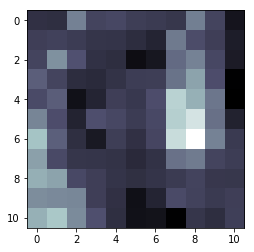

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
#roi.autoencoder()
idx = 2
_,decoded = roi.autoencoder(ds2.__getitem__(idx)['image'])
plt.imshow(np.reshape(decoded.cpu().detach().numpy(), (11,11)), cmap=plt.cm.bone) 

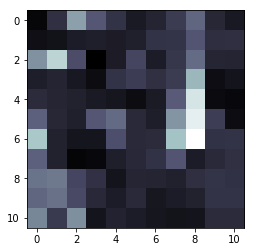

In [12]:
plt.imshow(np.reshape(roi.normalize_range(ds2.__getitem__(idx)['image'].cpu()).numpy(), (11,11)), cmap=plt.cm.bone) 

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.transforms import Compose
import transform_classes
import torch as th

th.cuda.set_device(0)

csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'
compose1 = Compose([transform_classes.ReScale64(),transform_classes.StandardScale(),transform_classes.ToTensor()])
compose2 = Compose([transform_classes.ReScale32(),transform_classes.ToTensor()])
ds = RoiDataset(csv_file, compose1, compose2,smpl = 8)

roi = RoiLearn()
roi.build_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(roi.model.parameters(),weight_decay = 0.0001)

dataset_loader = torch.utils.data.DataLoader(ds,batch_size=8, shuffle=False,num_workers=0)
ae_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\ae_w.pth'
roi.load_ae_weights(ae_weights_folder)
roi.ae_weights2model_feature_set()

In [14]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
roi.learn_roi(dataset_loader, optimizer, criterion, ep = 1000)

epoch:  0  loss:  466.09525545960145
epoch:  1  loss:  465.95512731079566
epoch:  2  loss:  465.7954471157728
epoch:  3  loss:  465.61479906755585
epoch:  4  loss:  465.41163640693355
epoch:  5  loss:  465.1845442714074
epoch:  6  loss:  464.9323815000877
epoch:  7  loss:  464.6544118357212
epoch:  8  loss:  464.35043027313145
epoch:  9  loss:  464.0208762215667
epoch:  10  loss:  463.6669169013404
epoch:  11  loss:  463.29047644117765
epoch:  12  loss:  462.894200174002
epoch:  13  loss:  462.48134878592043
epoch:  14  loss:  462.05562463711397
epoch:  15  loss:  461.62095262666134
epoch:  16  loss:  461.18124553399355
epoch:  17  loss:  460.74018961727387
epoch:  18  loss:  460.30107700568556
epoch:  19  loss:  459.86669469074076
epoch:  20  loss:  459.4392749094036
epoch:  21  loss:  459.0205074482894
epoch:  22  loss:  458.61160554179276
epoch:  23  loss:  458.2134075841502
epoch:  24  loss:  457.82649138483447
epoch:  25  loss:  457.4512795235422
epoch:  26  loss:  457.08812147384

epoch:  218  loss:  451.5070257984858
epoch:  219  loss:  451.50575550178553
epoch:  220  loss:  451.5045023426072
epoch:  221  loss:  451.5032665607897
epoch:  222  loss:  451.5020483271467
epoch:  223  loss:  451.500847745858
epoch:  224  loss:  451.49966485760086
epoch:  225  loss:  451.4984996433442
epoch:  226  loss:  451.49735202870795
epoch:  227  loss:  451.4962218887882
epoch:  228  loss:  451.495109053333
epoch:  229  loss:  451.4940133121561
epoch:  230  loss:  451.4929344206721
epoch:  231  loss:  451.49187210544227
epoch:  232  loss:  451.4908260696214
epoch:  233  loss:  451.48979599821246
epoch:  234  loss:  451.4887815630394
epoch:  235  loss:  451.4877824273679
epoch:  236  loss:  451.486798250112
epoch:  237  loss:  451.48582868958545
epoch:  238  loss:  451.4848734067682
epoch:  239  loss:  451.48393206807225
epoch:  240  loss:  451.48300434760904
epoch:  241  loss:  451.482089928968
epoch:  242  loss:  451.48118850653077
epoch:  243  loss:  451.48029978635367
epoch:

epoch:  435  loss:  451.4068364033915
epoch:  436  loss:  451.40666969621435
epoch:  437  loss:  451.4065040496656
epoch:  438  loss:  451.40633945550985
epoch:  439  loss:  451.40617590559145
epoch:  440  loss:  451.4060133918327
epoch:  441  loss:  451.40585190623347
epoch:  442  loss:  451.4056914408701
epoch:  443  loss:  451.4055319878946
epoch:  444  loss:  451.40537353953346
epoch:  445  loss:  451.4052160880869
epoch:  446  loss:  451.40505962592823
epoch:  447  loss:  451.4049041455027
epoch:  448  loss:  451.40474963932627
epoch:  449  loss:  451.4045960999857
epoch:  450  loss:  451.40444352013736
epoch:  451  loss:  451.40429189250557
epoch:  452  loss:  451.4041412098835
epoch:  453  loss:  451.4039914651307
epoch:  454  loss:  451.4038426511732
epoch:  455  loss:  451.40369476100307
epoch:  456  loss:  451.40354778767664
epoch:  457  loss:  451.4034017243149
epoch:  458  loss:  451.4032565641017
epoch:  459  loss:  451.40311230028414
epoch:  460  loss:  451.40296892617084

KeyboardInterrupt: 

In [18]:
roi.model.conv1.weight.requires_grad=True
roi.model.conv1.bias.requires_grad=True
roi.learn_roi(dataset_loader, optimizer, criterion, ep = 10)
print('Save weights')
save_model_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\model_w.pth'
roi.save_model_weights(save_model_weights_folder)

epoch:  0  loss:  451.3814063319843
epoch:  1  loss:  451.3813822503478
epoch:  2  loss:  451.3813582795631
epoch:  3  loss:  451.38133441902306
epoch:  4  loss:  451.3813106681244
epoch:  5  loss:  451.38128702626716
epoch:  6  loss:  451.3812634928546
epoch:  7  loss:  451.3812400672935
epoch:  8  loss:  451.3812167489942
epoch:  9  loss:  451.38119353736994
Save weights


[0.04006955]


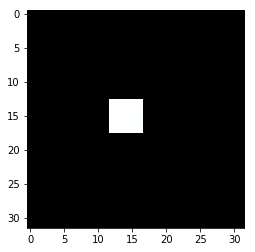

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
#roi.autoencoder()

idx = 0
out = roi.model(torch.from_numpy(np.expand_dims(ds.__getitem__(idx)['image'], axis = 0)).cuda())
#print(np.amax(out.detach().numpy() ))
print(np.amax(out.cpu().detach().numpy(),axis=1))
plt.imshow(np.reshape(out.cpu().detach().numpy(), (32,32)), cmap=plt.cm.bone)

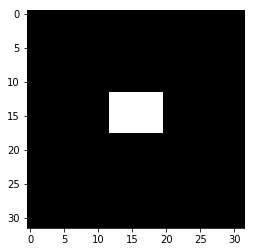

In [17]:
plt.imshow(np.reshape((ds.__getitem__(idx)['mask']).cpu().numpy(), (32,32)), cmap=plt.cm.bone)

In [247]:
torch.cuda.max_memory_allocated()

612979200